In [31]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
# Load Training Data

filename = "/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/trainingData/SGy139_TimeCourse_Jun9_23.xlsx"
df_br1 = pd.read_excel(filename, sheet_name="Bioreactor1")
df_br2 = pd.read_excel(filename, sheet_name="Bioreactor2")

df_br1.head()

,BatchTime,Phase,GrowthRate
0,0.000000,0.05,0.022972
1,0.016667,0.05,0.043676
2,0.033333,0.05,0.043676
3,0.050000,0.05,0.061904
4,0.066667,0.05,0.061904


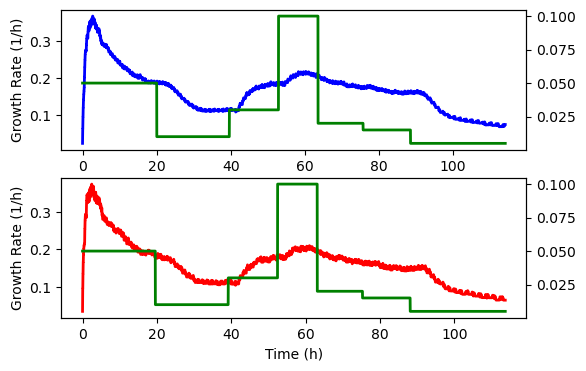

In [33]:
# Visualize Training Data

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1["BatchTime"], df_br1["GrowthRate"], linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1["BatchTime"], df_br1["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2["BatchTime"], df_br2["GrowthRate"], linewidth=2, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2["BatchTime"], df_br2["Phase"], linewidth=2, color="green", label="Bioreactor 2")

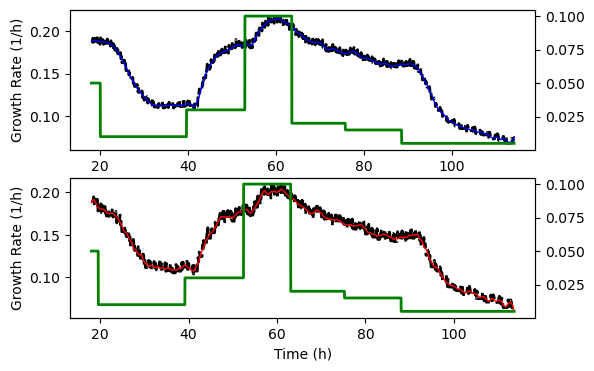

In [34]:
# Truncate and Smooth Data
from scipy.signal import savgol_filter

# Truncate data to remove initial lag phase
time_cutoff = 18
df_br1_trunc = df_br1[df_br1["BatchTime"] > time_cutoff].copy()
df_br2_trunc = df_br2[df_br2["BatchTime"] > time_cutoff].copy()

# Smooth data using Savitzky-Golay filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
# Parameters
window_size = 151
poly_order = 3
deriv = 0
df_br1_trunc["GrowthRateSmooth"] = savgol_filter(df_br1_trunc["GrowthRate"], window_size, poly_order, deriv=deriv)
df_br2_trunc["GrowthRateSmooth"] = savgol_filter(df_br2_trunc["GrowthRate"], window_size, poly_order, deriv=deriv)

# Visualize truncated and smoothed data
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1_trunc["BatchTime"], df_br1_trunc["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 1 (Raw)")
ax.plot(df_br1_trunc["BatchTime"], df_br1_trunc["GrowthRateSmooth"], linewidth=1, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1_trunc["BatchTime"], df_br1_trunc["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2_trunc["BatchTime"], df_br2_trunc["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 2 (Raw)")
ax.plot(df_br2_trunc["BatchTime"], df_br2_trunc["GrowthRateSmooth"], linewidth=1, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2_trunc["BatchTime"], df_br2_trunc["Phase"], linewidth=2, color="green", label="Bioreactor 2")

[0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1]
[0.0734547580486065, 0.11449916164970078, 0.16115651184315924, 0.17368609162895002, 0.1835650140137684, 0.18798828591981112, 0.2066117976456574]
[0.0010881118139570098, 0.00017922013821686667, 0.0001351855672608787, 0.00023040634511450214, 0.0003416015420552834, 9.79051449885469e-05, 0.0003940932568776185]
[0.06350886004033417, 0.11409157907206488, 0.14736955059094883, 0.1629574775336532, 0.1785494072864605, 0.18371385974925505, 0.194438254015791]
[0.0020202843944336297, 0.0005138569688471562, 0.00021633159036764683, 0.0003193719741695719, 0.00022387115608396834, 0.0006227661336243767, 0.0002279725263584661]


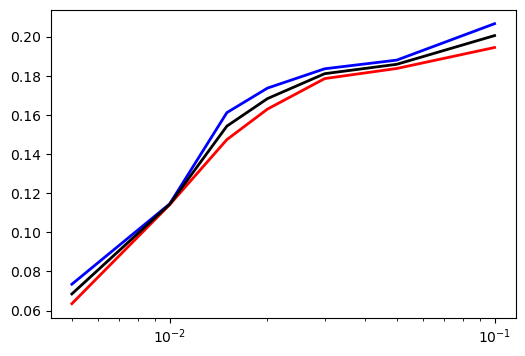

In [35]:
# Split dataframe by Phase

df_br1_trunc_grouped = df_br1_trunc.groupby("Phase")
df_br2_trunc_grouped = df_br2_trunc.groupby("Phase")

keys = list(df_br1_trunc_grouped.groups.keys())
print(keys)

mu_mean_br1 = []
mu_std_br1 = []
mu_mean_br2 = []
mu_std_br2 = []
mu_mean_overall = []
mu_std_overall = []

rangeme = 20

for key in keys:
    df = df_br1_trunc_grouped.get_group(key)
    mu_mean_br1.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br1.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    df = df_br2_trunc_grouped.get_group(key)
    mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    mu_mean_overall.append((mu_mean_br1[-1] + mu_mean_br2[-1])/2)
    mu_std_overall.append(np.sqrt(mu_std_br1[-1]**2 + mu_std_br2[-1]**2))
    

print(mu_mean_br1)
print(mu_std_br1)
print(mu_mean_br2)
print(mu_std_br2)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.semilogx(keys, mu_mean_br1, linewidth=2, color="blue", label="Bioreactor 1")
ax.semilogx(keys, mu_mean_br2, linewidth=2, color="red", label="Bioreactor 2")
ax.semilogx(keys, mu_mean_overall, linewidth=2, color="black", label="Overall")

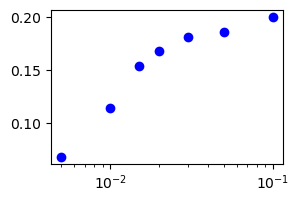

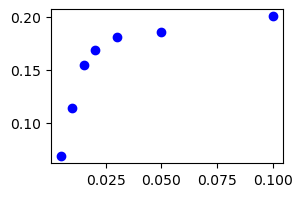

In [36]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.semilogx(keys, mu_mean_overall, 'o', linewidth=2, color="blue", label="Bioreactor 1")

fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.plot(keys, mu_mean_overall, 'o', linewidth=2, color="blue", label="Bioreactor 1")

In [37]:
# Load Training Data

filename = "/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/trainingData/SGy139_ActDeAct_Mar1_23.xlsx"
df_br1_actdeact = pd.read_excel(filename, sheet_name="Bioreactor1")
df_br2_actdeact = pd.read_excel(filename, sheet_name="Bioreactor2")

df_br1_actdeact.head()

,BatchTime,Phase,GrowthRate
0,0.000000,Batch_10%_1,0.021140
1,0.016667,Batch_10%_1,0.040492
2,0.033333,Batch_10%_1,0.040492
3,0.050000,Batch_10%_1,0.057788
4,0.066667,Batch_10%_1,0.057788


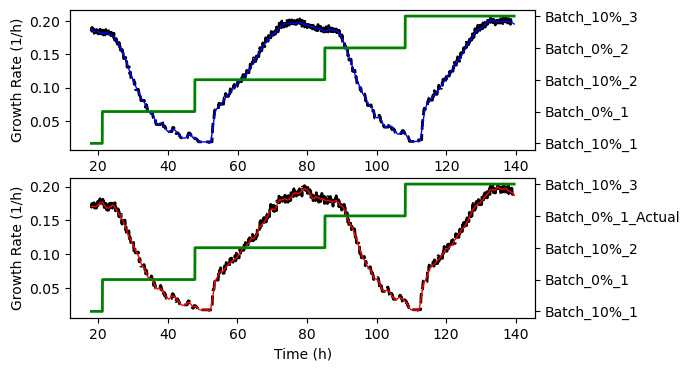

In [38]:
# Truncate and Smooth Data
from scipy.signal import savgol_filter

# Truncate data to remove initial lag phase
time_cutoff = 18
df_br1_trunc_actdeact = df_br1_actdeact[df_br1_actdeact["BatchTime"] > time_cutoff].copy()
df_br2_trunc_actdeact = df_br2_actdeact[df_br2_actdeact["BatchTime"] > time_cutoff].copy()

# Smooth data using Savitzky-Golay filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
# Parameters
window_size = 151
poly_order = 3
deriv = 0
df_br1_trunc_actdeact["GrowthRateSmooth"] = savgol_filter(df_br1_trunc_actdeact["GrowthRate"], window_size, poly_order, deriv=deriv)
df_br2_trunc_actdeact["GrowthRateSmooth"] = savgol_filter(df_br2_trunc_actdeact["GrowthRate"], window_size, poly_order, deriv=deriv)

# Visualize truncated and smoothed data
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 1 (Raw)")
ax.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["GrowthRateSmooth"], linewidth=1, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 2 (Raw)")
ax.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["GrowthRateSmooth"], linewidth=1, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["Phase"], linewidth=2, color="green", label="Bioreactor 2")

[0.0734547580486065, 0.11449916164970078, 0.16115651184315924, 0.17368609162895002, 0.1835650140137684, 0.18798828591981112, 0.2066117976456574]
[0.0010881118139570098, 0.00017922013821686667, 0.0001351855672608787, 0.00023040634511450214, 0.0003416015420552834, 9.79051449885469e-05, 0.0003940932568776185]
[0.06350886004033417, 0.11409157907206488, 0.14736955059094883, 0.1629574775336532, 0.1785494072864605, 0.18371385974925505, 0.194438254015791]
[0.0020202843944336297, 0.0005138569688471562, 0.00021633159036764683, 0.0003193719741695719, 0.00022387115608396834, 0.0006227661336243767, 0.0002279725263584661]


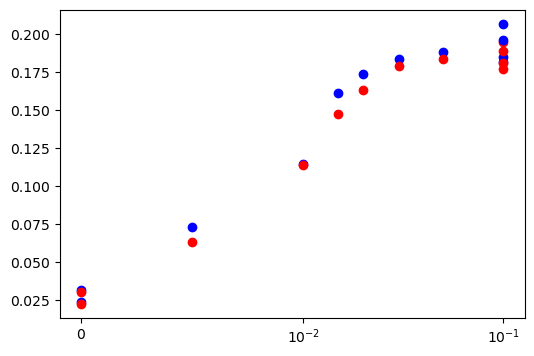

In [39]:
# Split dataframe by Phase

df_br1_trunc_actdeact_grouped = df_br1_trunc_actdeact.groupby("Phase")
df_br2_trunc_actdeact_grouped = df_br2_trunc_actdeact.groupby("Phase")

keys_br1_actdeact = list(df_br1_trunc_actdeact_grouped.groups.keys())
keys_br2_actdeact = list(df_br2_trunc_actdeact_grouped.groups.keys())

keys_add_br1 = []
keys_add_br2 = []


mu_mean_br1_actdeact = []
mu_std_br1_actdeact = []
mu_mean_br2_actdeact = []
mu_std_br2_actdeact = []

rangeme = 20

for key in keys_br1_actdeact:
    df = df_br1_trunc_actdeact_grouped.get_group(key)
    mu_mean_br1_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br1_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    # df = df_br2_trunc_actdeact_grouped.get_group(key)
    # mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    # mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    if '_0%' in key:
        keys_add_br1.append(0)
    elif '_10%' in key:
        keys_add_br1.append(0.1)

for key in keys_br2_actdeact:
    df = df_br2_trunc_actdeact_grouped.get_group(key)
    mu_mean_br2_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br2_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    # df = df_br2_trunc_actdeact_grouped.get_group(key)
    # mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    # mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    if '_0%' in key:
        keys_add_br2.append(0)
    elif '_10%' in key:
        keys_add_br2.append(0.1)

    

print(mu_mean_br1)
print(mu_std_br1)
print(mu_mean_br2)
print(mu_std_br2)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys, mu_mean_br1, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys, mu_mean_br2, 'o', linewidth=2, color="red", label="Bioreactor 2")
ax.plot(keys_add_br1, mu_mean_br1_actdeact, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys_add_br2, mu_mean_br2_actdeact, 'o', linewidth=2, color="red", label="Bioreactor 2")

ax.set_xscale('symlog', linthresh=0.01)

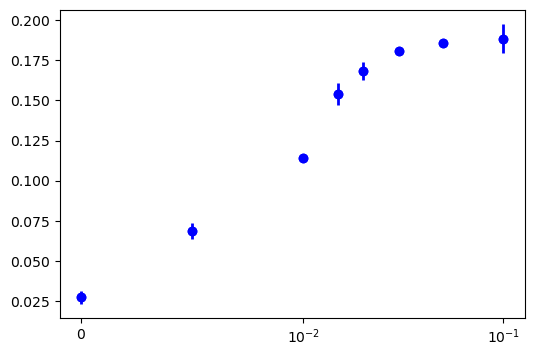

In [40]:
keys_plot = keys + keys + keys_add_br1 + keys_add_br2
mu_plot = mu_mean_br1 + mu_mean_br2 + mu_mean_br1_actdeact + mu_mean_br2_actdeact
mu_plot = np.array(mu_plot)
keys_plot = np.array(keys_plot)

mu_plot = mu_plot[np.argsort(keys_plot)]
keys_plot = keys_plot[np.argsort(keys_plot)]

keys_unique = np.unique(keys_plot)
mu_unique = []
mu_std_unique = []

for key in keys_unique:
    mu_unique.append(mu_plot[keys_plot == key].mean())
    mu_std_unique.append(mu_plot[keys_plot == key].std())


fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys_unique, mu_unique, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.errorbar(keys_unique, mu_unique, yerr=mu_std_unique, fmt='o', linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xscale('symlog', linthresh=0.01)


In [73]:
def khammash_ode_scaled(t,x,p_scaled,I):
    if callable(I):
        I = I(t)

    # Parameters
    k_alpha, k_beta, kbasal_scaled, kmax_scaled, n, Kd_scaled, kdegR = p_scaled

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])

    # k_alpha = kon / koff
    # k_beta = koff

    dTFondt = (I * k_alpha * (1 - TFon) - TFon) * k_beta
    # dTFondt = I * kon * (1 - TFon) - koff * TFon
    dmRNAdt = kbasal_scaled + kmax_scaled * (TFon ** n) / ((Kd_scaled ** n) + (TFon ** n)) - kdegR * mRNA

    return [dTFondt, dmRNAdt]


def khammash_ode(t,x,p,I):
    if callable(I):
        I = I(t)

    # Parameters
    kon, TFtot, koff, kbasal, kmax, n, Kd, kdegR, ktrans, kdegP = p

    # Variables
    TFon, mRNA = x
    TFon = np.max([0,TFon])
    mRNA = mRNA * (kbasal + kmax) / kdegR

    dTFondt = I * kon * (TFtot - (TFon  * TFtot)) - koff * (TFon  * TFtot)
    dmRNAdt = kbasal + kmax * ((TFon  * TFtot) ** n) / ((Kd ** n) + ((TFon  * TFtot) ** n)) - kdegR * mRNA

    dTFondt = dTFondt / TFtot
    dmRNAdt = dmRNAdt * kdegR / (kbasal + kmax)

    return [dTFondt, dmRNAdt]

def fsolve_func(x,period,I,max_step):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    # return (sol.y[:,-1] - x[:])
    return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def fsolve_func_scaled(x,period,I,max_step, p_scaled):
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=x, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    return (sol.y[:,-1] - x[:])
    # return sol.y[:,-1]
    # return (sol.y[:,-1] - x) * [1/10,10]

def I_fun_base(t, u, period, Imax):
    remainder = t - np.floor(t/period) * period
    I_out = np.zeros(np.array(t).size)
    I_out[remainder < u * period] = Imax
    return I_out

def steady_mRNA_solve(u, period, Imax, p_scaled, x_guess=None, fast=False):

    I = lambda t: I_fun_base(t, u, period, Imax)

    if x_guess is None:
        x_guess = [u,u]

    if u > 0:
        max_step = u*period
    else:
        max_step = period / 10

    # try:
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step), xtol=1e-9, maxiter=5000)
    # except:
    #     print('first one failed')
    #     x_guess = [u,u]
    #     sol = fixed_point(fsolve_func_scaled, x_guess, args=(period,I,max_step/10), xtol=1e-9, maxiter=5000)
    # steady = sol

    if fast:
        tol = 1e-3
    else:
        tol = 1e-9
        
    sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step, p_scaled), tol=tol)
    if not sol.success:
        x_guess = [u,u]
        sol = root(fsolve_func_scaled, x_guess, args=(period,I,max_step, p_scaled), tol=tol)

    steady = np.maximum(sol.x,[0,0])
    tspan = [0,period]
    sol = solve_ivp(khammash_ode_scaled, t_span=tspan, y0=steady, args=(p_scaled,I),
                        rtol=1e-9, atol=1e-12, 
                        # t_eval=np.linspace(tspan[0], tspan[1], 1000000), 
                        method='BDF',
                        first_step = 0.0001,
                        max_step=max_step,
                        )
    steady = np.trapz(sol.y, x=sol.t) / period

    return steady#, sol.success, sol.message, sol.fun

def opto_growth(t,x,p, p_EL222_Amp, p_EL222_Inv, p_light, od_sp=None):

    global u_current, setpoint_invert, setpoint_amp

    # Parameters
    kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp = p

    tau_mRNA = 1 / kdegR

    # Variables
    mRNA_invert, mRNA_amp, Rep, Amp, Enz_invert, Enz_amp, S, X_invert, X_amp = x
    # mRNA_blind = 1

    u, period, Imax = p_light

    if u_current != u:
        print('updating setpoints from ', u_current, ' to ', u)
        setpoint_invert = steady_mRNA_solve(u, period, Imax, p_EL222_Inv, x_guess=None)
        setpoint_amp = steady_mRNA_solve(u, period, Imax, p_EL222_Amp, x_guess=None)
        u_current = u

    mu_x_invert = mu_max_invert * Enz_invert * S / (Ks + S)
    mu_x_amp = mu_max_amp * Enz_amp * S / (Ks + S)

    dmRNA_invert_dt = (setpoint_invert[1] - mRNA_invert) / tau_mRNA
    dmRNA_amp_dt = (setpoint_amp[1] - mRNA_amp) / tau_mRNA
    
    dRepdt = ktrans * mRNA_invert * S / (Ks + S) - (kdegP + mu_x_invert) * Rep

    if Rep<0:
        dEnz_invert_dt = ktrans * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert
    else:
        dEnz_invert_dt = ktrans * (K_Rep ** n_Rep / (K_Rep ** n_Rep + Rep ** n_Rep)) * S / (Ks + S) - (kdegPPDC + mu_x_invert) * Enz_invert
    
    dAmpdt = ktrans * mRNA_amp * S / (Ks + S) - (kdegP + mu_x_amp) * Amp

    if Amp < 0:
        dEnz_amp_optodt =  - (kdegPPDC + mu_x_amp) * Enz_amp
    else:
        dEnz_amp_optodt = ktrans * (Amp ** n_Amp / (K_Amp ** n_Amp + Amp ** n_Amp)) * S / (Ks + S) - (kdegPPDC + mu_x_amp) * Enz_amp

    S0 = 20
    if od_sp is None:
        d = 0
    else:
        d = (mu_x_invert * X_invert + mu_x_amp * X_amp) / (X_invert + X_amp)
        if (X_invert + X_amp) < od_sp:
            d = 0
        elif (X_invert + X_amp) > od_sp:
            d = d #* (X_invert + X_amp)/od_sp
    
    # if setpoint[1] > 0.5:
    #     print(d)
    dSdt = - (mu_x_invert / Y) * X_invert - (mu_x_amp / Y) * X_amp + d * (S0 - S)
    dX_invert_dt = mu_x_invert * X_invert - d * X_invert
    dX_amp_dt = mu_x_amp * X_amp - d * X_amp

    # print(x)
    # print([dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt])
    return [dmRNA_invert_dt, dmRNA_amp_dt, dRepdt, dAmpdt, dEnz_invert_dt, dEnz_amp_optodt, dSdt, dX_invert_dt, dX_amp_dt]


In [84]:
# EL222 Parameters

# Mutual Parameters
TFtot = 2000
kon = 0.0016399 
kmax = 13.588
Kd = 956.75
n = 4.203
kdegR = 0.042116
ktrans = 1.4514
kdegP = 0.007

# Amp Parameters

koff_amp = 0.34393 #/ 2
kbasal_amp = 0.02612

p_amp =  kon, TFtot, koff_amp, kbasal_amp, kmax, n, Kd, kdegR, ktrans, kdegP


Kd_scaled = Kd / TFtot
kmax_scaled_amp = kmax * kdegR / (kbasal_amp + kmax)
kbasal_scaled_amp = kbasal_amp * kdegR / (kbasal_amp + kmax)
k_alpha_amp = kon * 10000 / koff_amp
k_beta_amp = koff_amp 

p_scaled_amp = k_alpha_amp, k_beta_amp, kbasal_scaled_amp, kmax_scaled_amp, n, Kd_scaled, kdegR

# Invert Parameters

koff_invert = 0.34393
kbasal_invert = 0.02612 

p_invert = kon, TFtot, koff_invert, kbasal_invert, kmax, n, Kd, kdegR, ktrans, kdegP

Kd_scaled = Kd / TFtot
kmax_scaled_invert = kmax * kdegR / (kbasal_invert + kmax)
kbasal_scaled_invert = kbasal_invert * kdegR / (kbasal_invert + kmax)
k_alpha_invert = kon * 10000 / koff_invert
k_beta_invert = koff_invert

p_scaled_invert = k_alpha_invert, k_beta_invert, kbasal_scaled_invert, kmax_scaled_invert, n, Kd_scaled, kdegR


In [94]:
# Light Parameters
period = 100 / 60
Imax = 1

In [95]:
x_ss = steady_mRNA_solve(0.5, period, Imax, p_scaled_amp, x_guess=None, fast=True)
print(x_ss)

[0.9067915  0.93116377]


In [96]:
x_ss = steady_mRNA_solve(0.5, period, Imax, p_scaled_amp, x_guess=x_ss, fast=True)

In [97]:
from scipy.optimize import fsolve
from tqdm import tqdm

# Inverted Circuit
# 
# u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))
Ks = 1
Y = 0.5

kdegR = 0.042116
ktrans = 1.4514
kdegP = np.log(2) / (6 * 60)
kdegPPDC = np.log(2) / (12 * 60)
K_Rep = 1
n_Rep = 2
mu_max_invert = 0.47 / 60

K_Amp = 1
mu_max_amp = 0.5 / 60
n_Amp = 2

optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp


od_sp = 0.01

S = 20 - 2 / Y

u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

steady_state_arr_invert = np.zeros((u_arr.size, 9))
steady_state_arr_amp = np.zeros((u_arr.size, 9))

global u_current, setpoint_amp, setpoint_invert

u_current = 1.0
setpoint_amp = steady_mRNA_solve(u_current, period, Imax, p_scaled_amp, x_guess=None, fast=True)
setpoint_invert = steady_mRNA_solve(u_current, period, Imax, p_scaled_invert, x_guess=None, fast=True)

x_init_amp = [0, 0, 0, 0, 0, 0, 20, 0, 0.0]
x_init_inv = [0, 0, 0, 0, 0, 0, 20, 0, 0.0]

for index, u in tqdm(enumerate(u_arr), total=u_arr.size):
    p_light = u, period, Imax


    x_init_inv[-2] = 0.1
    x_init_inv[-1] = 0.
    tspan = np.array([0, 500*60])
    optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, mu_max_invert, 0, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp

    # def opto_growth(t,x,p, p_EL222_Amp, p_EL222_Inv, p_light, od_sp=None):
    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init_inv, args=(optogrowth_p, p_scaled_amp, p_scaled_invert, p_light, od_sp),
                        rtol=1e-6, atol=1e-9, 
                        method='BDF',
                        first_step = 0.0001,
                        )
#     print('solveIvp', sol.message)
    x_init_inv = sol.y[:,-1]

    mask = np.array([1, 1, 1, 1, 1, 1, 0, 0, 0])
    steady_state, infodict, ier, mesg = fsolve(lambda x: opto_growth(0, x, optogrowth_p, p_scaled_amp, p_scaled_invert, p_light, od_sp)*mask, x_init_inv, xtol=1e-6, maxfev=100000, full_output=True, factor=0.1)
    # print(mesg)
    # print('invert' , mesg)
    steady_state_arr_invert[index,:] = steady_state

    optogrowth_p = kdegR, ktrans, kdegP, kdegPPDC, 0, mu_max_amp, Ks, Y, K_Rep, K_Amp, n_Rep, n_Amp


    tspan = np.array([0, 500*60])
    x_init_amp[-2] = 0.
    x_init_amp[-1] = 0.1
    sol = solve_ivp(opto_growth, t_span=tspan, y0=x_init_amp, args=(optogrowth_p, p_scaled_amp, p_scaled_invert, p_light, od_sp),
                        rtol=1e-6, atol=1e-9, 
                        method='BDF',
                        first_step = 0.0001,
                        )
#     print('solveIvp', sol.message)
    x_init = sol.y[:,-1]
#     plt.figure()
#     plt.plot(sol.t / 60, sol.y[5,:], label='Enz_amp')


    steady_state, infodict, ier, mesg = fsolve(lambda x: opto_growth(0, x, optogrowth_p, p_scaled_amp, p_scaled_invert, p_light, od_sp)*mask, x_init, xtol=1e-9, maxfev=100000, full_output=True, factor=0.1)
#     print('amp', mesg)
    steady_state_arr_amp[index,:] = steady_state

    # print(steady_state)
#     if index == 0:
#         assert False

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|▉         | 2/21 [00:01<00:15,  1.23it/s]

updating setpoints from  1.0  to  0.6951927961775606
updating setpoints from  0.6951927961775606  to  0.4832930238571752


 14%|█▍        | 3/21 [00:02<00:17,  1.01it/s]

updating setpoints from  0.4832930238571752  to  0.3359818286283781


 19%|█▉        | 4/21 [00:03<00:16,  1.01it/s]

updating setpoints from  0.3359818286283781  to  0.23357214690901212


 24%|██▍       | 5/21 [00:05<00:16,  1.05s/it]

updating setpoints from  0.23357214690901212  to  0.1623776739188721


 29%|██▊       | 6/21 [00:06<00:17,  1.19s/it]

updating setpoints from  0.1623776739188721  to  0.11288378916846883


 33%|███▎      | 7/21 [00:07<00:16,  1.15s/it]

updating setpoints from  0.11288378916846883  to  0.07847599703514611


 38%|███▊      | 8/21 [00:08<00:15,  1.16s/it]

updating setpoints from  0.07847599703514611  to  0.05455594781168517


 43%|████▎     | 9/21 [00:10<00:14,  1.24s/it]

updating setpoints from  0.05455594781168517  to  0.0379269019073225


 48%|████▊     | 10/21 [00:11<00:15,  1.38s/it]

updating setpoints from  0.0379269019073225  to  0.026366508987303583


 52%|█████▏    | 11/21 [00:13<00:15,  1.54s/it]

updating setpoints from  0.026366508987303583  to  0.018329807108324356


 57%|█████▋    | 12/21 [00:16<00:17,  1.89s/it]

updating setpoints from  0.018329807108324356  to  0.012742749857031334


 62%|██████▏   | 13/21 [00:19<00:17,  2.16s/it]

updating setpoints from  0.012742749857031334  to  0.008858667904100823


 67%|██████▋   | 14/21 [00:23<00:19,  2.84s/it]

updating setpoints from  0.008858667904100823  to  0.006158482110660267


 71%|███████▏  | 15/21 [00:28<00:19,  3.33s/it]

updating setpoints from  0.006158482110660267  to  0.004281332398719396


 76%|███████▌  | 16/21 [00:33<00:20,  4.02s/it]

updating setpoints from  0.004281332398719396  to  0.002976351441631319


 81%|████████  | 17/21 [00:38<00:16,  4.24s/it]

updating setpoints from  0.002976351441631319  to  0.00206913808111479


 86%|████████▌ | 18/21 [00:44<00:13,  4.64s/it]

updating setpoints from  0.00206913808111479  to  0.0014384498882876629


 90%|█████████ | 19/21 [00:52<00:11,  5.74s/it]

updating setpoints from  0.0014384498882876629  to  0.001


100%|██████████| 21/21 [01:03<00:00,  3.03s/it]

updating setpoints from  0.001  to  0.0


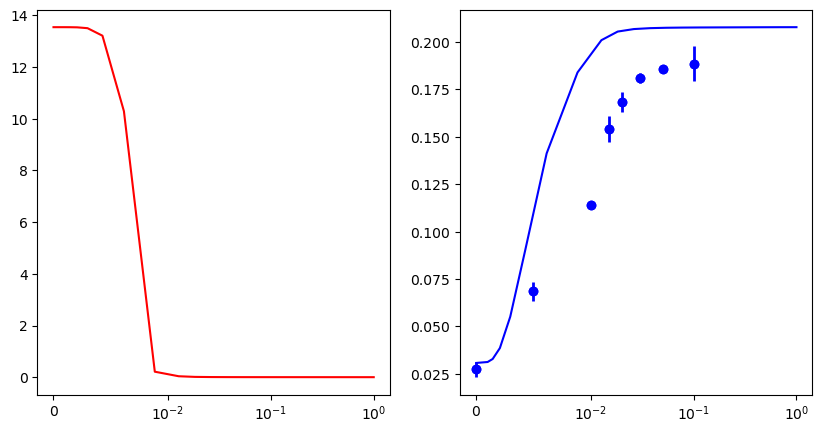

In [110]:
Enz_invert_arr = steady_state_arr_invert[:, 4]
Enz_amp_arr = steady_state_arr_amp[:, 5]
S0 = 20
mu_arr_invert = mu_max_invert * Enz_invert_arr * S0 / (Ks + S0) * 60
mu_arr_amp = mu_max_amp * Enz_amp_arr * S0 / (Ks + S0) * 60 / 30

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(u_arr, steady_state_arr_invert[:,4], '-', color='red', label='mu')
# ax.plot(u_arr, steady_state_arr_invert[:,4], '-', color='blue', label='mu')
# ax.plot(u_arr, mu_arr_invert, '-', color='blue', label='mu')
ax.set_xscale('symlog', linthresh=0.01)

ax = fig.add_subplot(122)
# ax.plot(u_arr, steady_state_arr_amp[:,5], '-', color='red', label='mu')
# ax.plot(u_arr, steady_state_arr_amp[:,5], '-', color='blue', label='mu')
ax.plot(u_arr, mu_arr_amp, '-', color='blue', label='mu')
ax.plot(keys_unique, mu_unique, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.errorbar(keys_unique, mu_unique, yerr=mu_std_unique, fmt='o', linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xscale('symlog', linthresh=0.01)

In [103]:
from tqdm import tqdm

u_arr = np.flip(np.concatenate((np.array([0]),10 ** np.linspace(-3,0,20))))

# u_arr = np.flip(10 ** np.linspace(-1,0,100))
Enz_arr = np.zeros(u_arr.size)
mRNA_arr_amp = np.zeros(u_arr.size)
mRNA_arr_invert = np.zeros(u_arr.size)

setpoint_amp = None
setpoint_invert = None

for i, u in tqdm(enumerate(u_arr), total=u_arr.size):
    # print(u)
    period = 100 / 60
    Imax = 1
    setpoint_amp = steady_mRNA_solve(u, period, Imax, p_scaled_amp, x_guess=setpoint_amp)
    # print(setpoint)
    mRNAss = setpoint_amp[1]
    mRNA_arr_amp[i] = mRNAss

    setpoint_invert = steady_mRNA_solve(u, period, Imax, p_scaled_invert, x_guess=setpoint_invert)

    mRNAss = setpoint_invert[1]
    mRNA_arr_invert[i] = mRNAss


 14%|█▍        | 3/21 [00:02<00:12,  1.39it/s]


KeyboardInterrupt: 

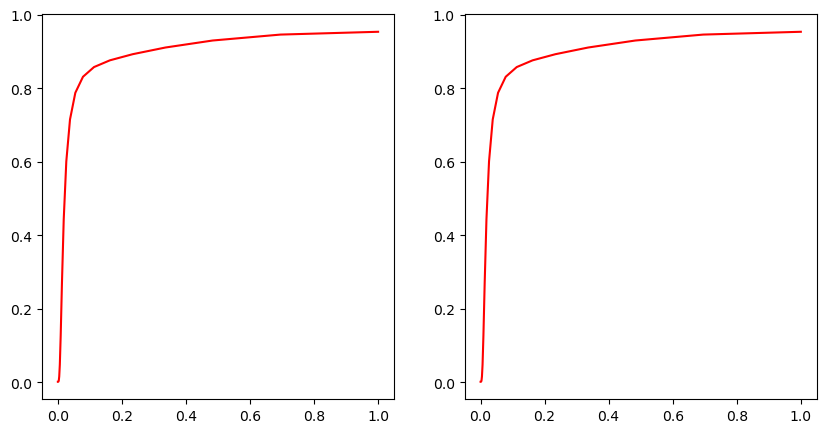

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(u_arr, mRNA_arr_invert, '-', color='red', label='mu')

ax = fig.add_subplot(122)
ax.plot(u_arr, mRNA_arr_amp, '-', color='red', label='mu')